In [3]:
import random
import numpy as np
from sklearn import datasets
from importlib import reload
import matplotlib.pyplot as plt
import time
import pandas as pd

### Reload modules after changes

In [22]:
import __init__
import distributions
import kernel
import fuzzifier
import optimization

reload(__init__)
reload(distributions)
reload(kernel)
reload(fuzzifier)
reload(optimization)

from __init__ import *
from distributions import *
from kernel import *
from fuzzifier import *
from optimization import *

In [122]:
from mulearn import FuzzyInductor as fz
from mulearn.kernel import LinearKernel as link
from mulearn.fuzzifier import LinearFuzzifier as linf

## Testing

In [9]:
def generate_dataset(n_samples=10, n_features=1):

    #random.seed(42)
    
    X = np.zeros((n_samples, n_features))

    for elem in range(n_samples):
        for dim in range(n_features):
            X[elem][dim] = random.uniform(0,1)

    gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

    y = np.zeros(n_samples)
    
    for elem in range(n_samples):
        y[elem] = 1
        for dim in range(n_features):
            y[elem] *= gaussian(X[elem][dim], np.var([X[j][dim] for j in range(n_samples)]))
                          
    
    return X,y

In [76]:
X,y = generate_dataset(n_samples=100,n_features=1)

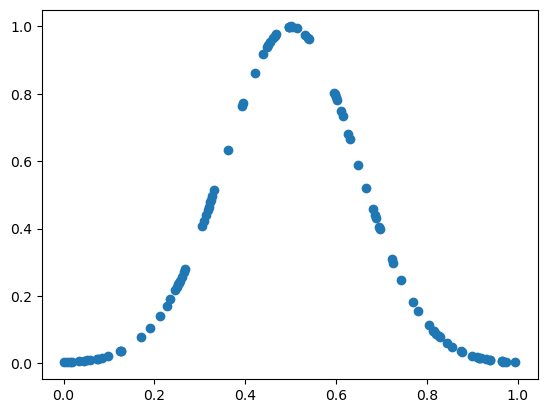

In [77]:
plt.scatter(X,y)
plt.show()

In [ ]:
X,y = generate_dataset(n_samples=1500,n_features=1)

In [7]:
model = FuzzyInductor()

In [130]:
s_time = time.time()
model.fit(X=X, y=y)
print("Fit time: ", time.time() - s_time)
print("Dataset size: ", len(X))

Fit time:  59.946744203567505
Dataset size:  1500


In [131]:
model2 = fz() #original mulearn

In [132]:
s_time = time.time()
model2.fit(X=X, y=y)
print("Fit time: ", time.time() - s_time)
print("Dataset size: ", len(X))

Fit time:  81.94515299797058
Dataset size:  1500


## Cooper testing

In [61]:
X, mus = generate_dataset(1000)

In [74]:
model_cooper = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=CooperSolver(atol=0.01,n_iter=5000,lr=1e-3, device='cpu'))
model_gurobi = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(), solver=GurobiSolver())

In [75]:
model_cooper

FuzzyInductor(c=1, k=GaussianKernel(), f=ExponentialFuzzifier(), solver=CooperSolver(, n_iter=5000, atol=0.01))

In [76]:
s = time.time()
model_cooper.fit(X, mus)
print("time:", time.time()-s)

time: 25.542489290237427


In [77]:
s = time.time()
model_gurobi.fit(X, mus)
print("time:", time.time()-s)

time: 26.0446355342865


In [78]:
kern = GaussianKernel()
k = np.array([[kern.compute(x1, x2) for x1 in X] for x2 in X])

chis_c = np.array(model_cooper.chis_)
chis_g = np.array(model_gurobi.chis_)

print('cooper solution:', -chis_c.dot(np.diag(k)) + chis_c.dot(k.dot(chis_c)))
print('gurobi solution:', -chis_g.dot(np.diag(k)) + chis_g.dot(k.dot(chis_g)))

cooper solution: -0.34285741629405386
gurobi solution: -0.37322491455810347


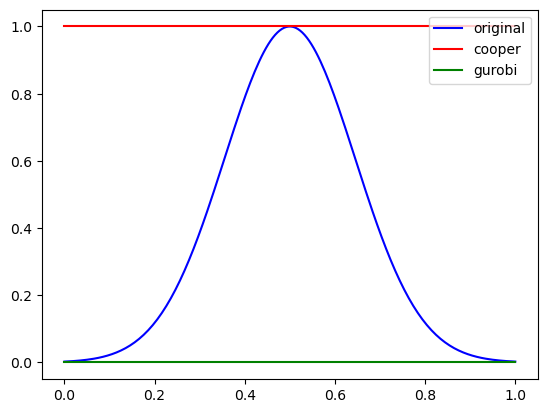

In [79]:
gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

X_new = np.linspace(0, 1, 200).reshape(-1, 1)
y_new = gaussian(X_new, var=np.var(X_new))

y_pred_cooper = model_cooper.predict(X_new)
y_pred_gurobi = model_gurobi.predict(X_new)

plt.plot(X_new, y_new, color='blue', label="original")
plt.plot(X_new, y_pred_cooper, color='red',  label="cooper")
plt.plot(X_new, y_pred_gurobi, color='green', label="gurobi")
plt.legend(loc="upper right")
plt.show()

In [274]:
X, mus = generate_dataset(5000)

In [81]:
model_cooper = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=CooperSolver(atol=0.01,n_iter=5000,lr=1e-3, device='gpu'))
s = time.time()
model_cooper.fit(X, mus)
print("time:", time.time()-s)

cooper: optimal values not found


time: 605.8112759590149


In [82]:
model_gurobi = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=GurobiSolver())
s = time.time()
model_gurobi.fit(X, mus)
print("time:", time.time()-s)

time: 641.4228239059448


In [276]:
kern = GaussianKernel()
s = time.time()
k = [[kern.compute(x1, x2) for x1 in X] for x2 in X]
print('time:', time.time() - s)

time: 141.54320216178894


## Fuzzy set shape testing

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import PredefinedSplit



kernels_d = {'linear' : [LinearKernel()],
             
             'polynomial' : [PolynomialKernel(2),\
                             PolynomialKernel(3),\
                             PolynomialKernel(4),\
                             PolynomialKernel(5)],
             
             'homogeneous_polynomial' : [HomogeneousPolynomialKernel(2), HomogeneousPolynomialKernel(3),\
                                         HomogeneousPolynomialKernel(4), HomogeneousPolynomialKernel(5)],
             
             'gaussian' : [GaussianKernel(1), GaussianKernel(0.5), GaussianKernel(0.1), GaussianKernel(0.05)],
             
             'hyperbolic' : [HyperbolicKernel(scale=1,offset=0), HyperbolicKernel(scale=1,offset=1),\
                             HyperbolicKernel(scale=0.5,offset=0), HyperbolicKernel(scale=0.5,offset=1),\
                             HyperbolicKernel(scale=2,offset=0), HyperbolicKernel(scale=2,offset=1)]}

fuzzifiers_d = {'crisp' : [CrispFuzzifier(profile='fixed'),\
                           CrispFuzzifier(profile='infer')],
                
                'linear' : [LinearFuzzifier(profile='fixed'),\
                            LinearFuzzifier(profile='infer')],
                
                'exponential' : [ExponentialFuzzifier(profile='fixed'), ExponentialFuzzifier(profile='infer'),\
                                 ExponentialFuzzifier(profile='alpha', alpha=2),\
                                 ExponentialFuzzifier(profile='alpha', alpha=1),\
                                 ExponentialFuzzifier(profile='alpha', alpha=0.5),\
                                 ExponentialFuzzifier(profile='alpha', alpha=0.05)],
                
                'quantile_constant' : [QuantileConstantPiecewiseFuzzifier()],
                
                'quantile_linear' : [QuantileLinearPiecewiseFuzzifier()]}

kernels = ['linear', 'polynomial', 'homogeneous_polynomial', 'gaussian', 'hyperbolic']
fuzzifiers = ['crisp', 'linear', 'exponential', 'quantile_constant', 'quantile_linear']

X, y = generate_dataset(n_samples=1000, n_features=1)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold = split_index)

X_new = np.linspace(0, 1, 200).reshape(-1, 1)

gridx, gridy = 25, 1
k = 1

plt.figure(figsize=(3, 100))

for kernel in kernels:
    for fuzzifier in fuzzifiers:

        params = {'c' : [0.01, 0.1, 1],
                  'k' : kernels_d[kernel],
                  'fuzzifier' : fuzzifiers_d[fuzzifier],
                  'solver' : [GurobiSolver(adjustment='auto')]}

        
        model = FuzzyInductor()

        clf = GridSearchCV(estimator=model, cv=pds, param_grid=params, n_jobs=-1) 
        clf.fit(X, np.ravel(y))
    

        clf.best_estimator_.fit(X_train, np.ravel(y_train))

        font = {'size' : 7}
        
        plt.subplot(gridx,gridy,k)
        plt.title(clf.best_estimator_.__repr__(), fontdict=font)
        plt.plot(X_new, clf.best_estimator_.predict(X_new), color='green')

        gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

        plt.plot(X_new, gaussian(X_new, np.var(X_new)))
        
        k+=1

plt.show()



### Gaussian membership

In [197]:
model = FuzzyInductor(c=0.007, k=GaussianKernel(sigma=0.5), fuzzifier=ExponentialFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [198]:
X, y = generate_dataset(500)

In [199]:
model.fit(X,y)

FuzzyInductor(c=0.007, k=GaussianKernel(sigma=0.5), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=0))

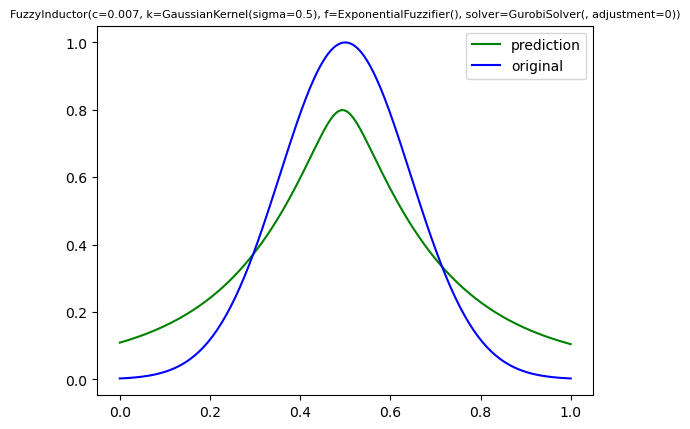

In [200]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

In [201]:
model = FuzzyInductor(c=0.01, k=GaussianKernel(sigma=0.5), fuzzifier=LinearFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [202]:
X, y = generate_dataset(500)

In [203]:
model.fit(X,y)

FuzzyInductor(c=0.01, k=GaussianKernel(sigma=0.5), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=0))

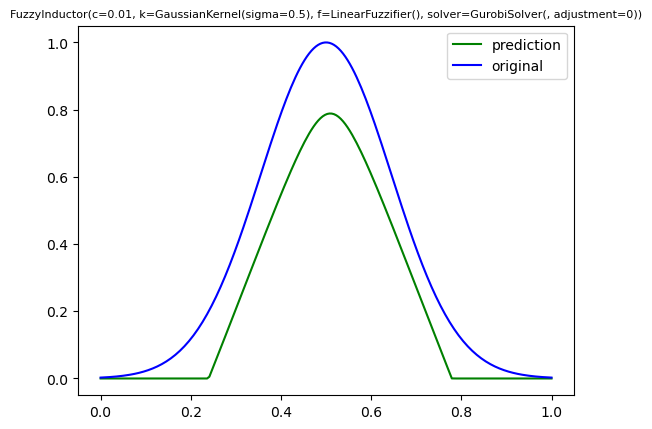

In [204]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### Triangular membership

In [205]:
model = FuzzyInductor(c=1, k=LinearKernel(), fuzzifier=LinearFuzzifier(profile='fixed'),\
                      solver=GurobiSolver(adjustment='auto'))

In [206]:
X, y = generate_dataset(500)

In [207]:
model.fit(X,y)

FuzzyInductor(c=1, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=0))

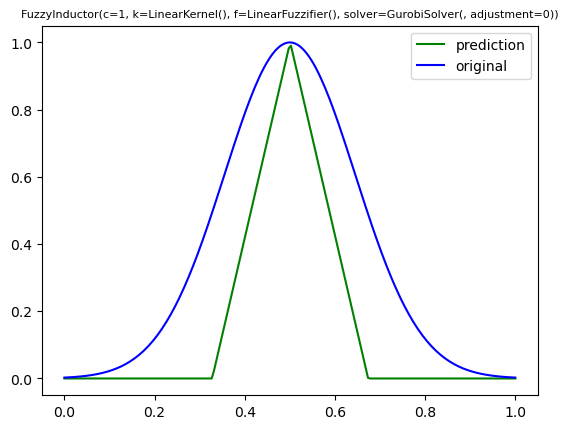

In [208]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### Rectangular membership

In [193]:
model = FuzzyInductor(c=0.01, k=PolynomialKernel(degree=2), fuzzifier=CrispFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [194]:
X, y = generate_dataset(500)

In [195]:
model.fit(X,y)

FuzzyInductor(c=0.01, k=PolynomialKernel(2), f=CrispFuzzifier(), solver=GurobiSolver(, adjustment=0))

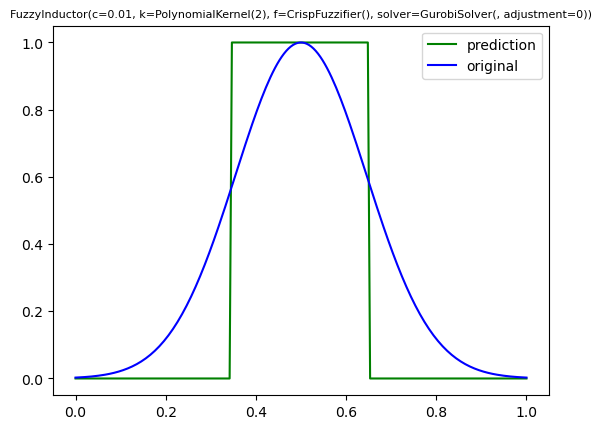

In [196]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### "Trapezoidal" membership (?)

In [265]:
model = FuzzyInductor(c=0.1, k=GaussianKernel(sigma=0.1), fuzzifier=QuantileLinearPiecewiseFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [266]:
X, y = generate_dataset(500)

In [267]:
model.fit(X,y)

FuzzyInductor(c=0.1, k=GaussianKernel(sigma=0.1), f=QuantileLinearPiecewiseFuzzifier(), solver=GurobiSolver(, adjustment=0))

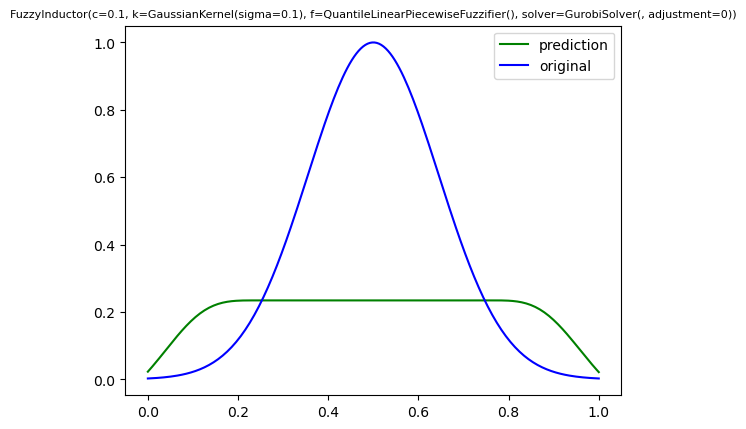

In [268]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()